In [1]:
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras import layers, losses, models, optimizers
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
rc['font.size']=12
import random

[0.6486371  1.1960331  0.10596634]


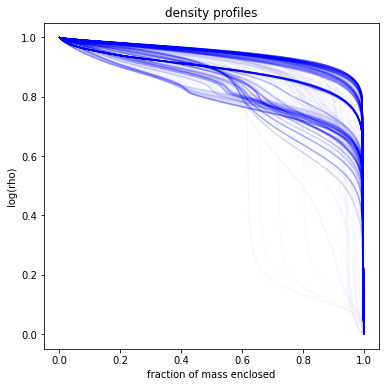

In [2]:
# dataset format:  m1, m2, p, final mass, normalized mass_enc profile,
#  central log(temperature), scaled temperature profile
data1 = np.load("normalized_logrho_profiles.npy",allow_pickle=True)
valid = np.load("normalized_logrho_validation_profiles.npy", allow_pickle=True)
data = random.sample(list(data1), 5000)

m1 = np.array([prof.get('m1') for prof in data], dtype='f') # initial stellar mass
m2 = np.array([prof.get('m2') for prof in data], dtype='f')
p = np.array([prof.get('p') for prof in data], dtype='f') # initial orbital period
linear_x = np.array(np.transpose([m1,m2,p]),dtype='f')

x = np.log10(linear_x) # 3d inputs for NN

linear_final_mass = np.array([prof.get('final_mass') for prof in data],dtype="f") # final stellar mass
final_mass = np.log10(linear_final_mass)

rho_min = np.array([prof.get('min_logrho') for prof in data], dtype='f')
rho_max = np.array([prof.get('max_logrho') for prof in data], dtype='f')

mass_points = data[0].get('m_arr') # x-values for normalized profiles

rho_minmax = np.array([[prof.get('min_logrho'), prof.get('max_logrho')] for prof in data], dtype='f')

# scaled density profiles
prof_true = np.array([prof.get('logrho_arr') for prof in data],dtype='f')

print(linear_x[0])

# plotting the density data (first 1000)
plt.figure(figsize=(6,6))
for i in range(1000):
    plt.plot(mass_points,prof_true[i],alpha=0.02,c='b')
plt.xlabel("fraction of mass enclosed")
plt.ylabel("log(rho)")
plt.title("density profiles")
plt.show()

In [3]:
valid_m1 = np.array([prof.get('m1') for prof in valid], dtype='f') # initial stellar mass
valid_m2 = np.array([prof.get('m2') for prof in valid], dtype='f')
valid_p = np.array([prof.get('p') for prof in valid], dtype='f') # initial orbital period
valid_linear_x = np.array(np.transpose([valid_m1,valid_m2,valid_p]),dtype='f')

valid_x = np.log10(valid_linear_x) # 3d inputs for NN

valid_linear_final_mass = np.array([prof.get('final_mass') for prof in valid],dtype="f") # final stellar mass
valid_final_mass = np.log10(valid_linear_final_mass)

valid_rho_min = np.array([prof.get('min_logrho') for prof in valid], dtype='f')
valid_rho_max = np.array([prof.get('max_logrho') for prof in valid], dtype='f')

valid_mass_points = valid[0].get('m_arr') # x-values for normalized profiles

valid_rho_minmax = np.array([[prof.get('min_logrho'), prof.get('max_logrho')] for prof in valid], dtype='f')

# scaled density profiles
valid_prof_true = np.array([prof.get('logrho_arr') for prof in valid],dtype='f')

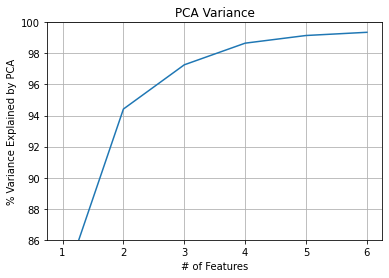

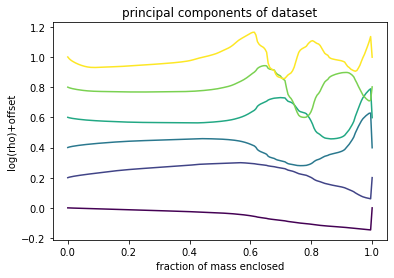

In [4]:
pca = PCA(n_components=6).fit(prof_true) # training PCA

plt.figure()
plt.ylabel('% Variance Explained by PCA')
plt.xlabel('# of Features')
plt.title('PCA Variance')
plt.ylim(86,100)
plt.plot(np.arange(1,len(pca.components_)+1),\
         np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid()

plt.show()

colors = plt.cm.viridis(np.linspace(0,1,len(pca.components_)))
plt.figure()
for i in range(len(pca.components_)):
    plt.plot(mass_points,pca.components_[i]+0.2*i,c=colors[i])
plt.xlabel("fraction of mass enclosed")
plt.ylabel("log(rho)+offset")
plt.title("principal components of dataset")
plt.show()

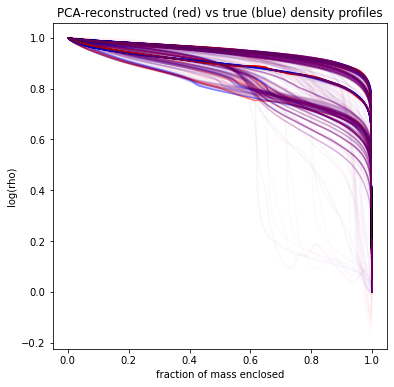

In [5]:
prof_low_unscaled = pca.transform(prof_true) # PCA weights 

# scaling factor: st dev of each component
sc = np.std(prof_low_unscaled,axis=0)
prof_low = prof_low_unscaled/sc # scaled pca weights: 6-d NN outputs
reconst = pca.inverse_transform(prof_low*sc) # PCA reconstructed data

# plotting for the first 1000 points out of 38000 because it gets too cluttered
plt.figure(figsize=(6,6))
for i in range(1000):
    plt.plot(mass_points,prof_true[i],alpha=0.02,c='b')
    plt.plot(mass_points,reconst[i],alpha=0.02,c='r')
plt.xlabel("fraction of mass enclosed")
plt.ylabel("log(rho)")
plt.title("PCA-reconstructed (red) vs true (blue) density profiles")
plt.show()

In [6]:
model = models.Sequential([
    layers.Dense(200,input_dim=6,trainable=False,activation="linear")
])

model.layers[0].set_weights([pca.components_, np.zeros(200)])
model.layers[0].get_weights()

regress = lambda x: model(x)

In [7]:
test_x = np.array([[1.,2.,3.,4.,5.,6.]])
out = regress(test_x)
real_x = np.array([[1.,2.,3.,4.,5.,6.],[2.,5.,4.,7.,9.,4.],[3.,6.,2.,9.,2.,12.],[4.,7.,2.,14.,8.,4.]])

In [8]:
print(out)

tf.Tensor(
[[-5.6786365e-07 -9.0652183e-02 -1.5537822e-01 -2.0783611e-01
  -2.5264105e-01 -2.9205635e-01 -3.2801843e-01 -3.6003754e-01
  -3.8919970e-01 -4.1532868e-01 -4.3900579e-01 -4.5974809e-01
  -4.7703797e-01 -4.9158406e-01 -5.0243127e-01 -5.0974214e-01
  -5.1264471e-01 -5.1377171e-01 -5.1424956e-01 -5.1127517e-01
  -5.0885773e-01 -5.0449079e-01 -5.0110668e-01 -4.9693674e-01
  -4.9180654e-01 -4.8661831e-01 -4.8127747e-01 -4.7824842e-01
  -4.7492480e-01 -4.7170392e-01 -4.6859252e-01 -4.6521014e-01
  -4.6268204e-01 -4.5908314e-01 -4.5449680e-01 -4.4948381e-01
  -4.4428945e-01 -4.3905914e-01 -4.3388128e-01 -4.2879969e-01
  -4.2340788e-01 -4.1815615e-01 -4.1304523e-01 -4.0789029e-01
  -4.0253937e-01 -3.9717948e-01 -3.9175057e-01 -3.8619989e-01
  -3.8054836e-01 -3.7502939e-01 -3.6947757e-01 -3.6379373e-01
  -3.5709554e-01 -3.5142168e-01 -3.4545889e-01 -3.3819842e-01
  -3.3178532e-01 -3.2417899e-01 -3.1734747e-01 -3.1048286e-01
  -3.0434424e-01 -2.9795587e-01 -2.9167500e-01 -2.8536844e-

In [9]:
comb = 0
for i in range(len(test_x[0])):
    comb += test_x[0][i]*pca.components_[i]
print(comb.shape)
print(comb)

(200,)
[-5.6786365e-07 -9.0652183e-02 -1.5537822e-01 -2.0783611e-01
 -2.5264105e-01 -2.9205635e-01 -3.2801843e-01 -3.6003754e-01
 -3.8919970e-01 -4.1532868e-01 -4.3900579e-01 -4.5974809e-01
 -4.7703797e-01 -4.9158406e-01 -5.0243127e-01 -5.0974214e-01
 -5.1264471e-01 -5.1377171e-01 -5.1424956e-01 -5.1127517e-01
 -5.0885773e-01 -5.0449079e-01 -5.0110668e-01 -4.9693674e-01
 -4.9180654e-01 -4.8661831e-01 -4.8127747e-01 -4.7824842e-01
 -4.7492480e-01 -4.7170392e-01 -4.6859252e-01 -4.6521014e-01
 -4.6268204e-01 -4.5908314e-01 -4.5449680e-01 -4.4948381e-01
 -4.4428945e-01 -4.3905914e-01 -4.3388128e-01 -4.2879969e-01
 -4.2340788e-01 -4.1815615e-01 -4.1304523e-01 -4.0789029e-01
 -4.0253937e-01 -3.9717948e-01 -3.9175057e-01 -3.8619989e-01
 -3.8054836e-01 -3.7502939e-01 -3.6947757e-01 -3.6379373e-01
 -3.5709554e-01 -3.5142168e-01 -3.4545889e-01 -3.3819842e-01
 -3.3178532e-01 -3.2417899e-01 -3.1734747e-01 -3.1048286e-01
 -3.0434424e-01 -2.9795587e-01 -2.9167500e-01 -2.8536844e-01
 -2.7882999e-01 -

In [10]:
out==comb

<tf.Tensor: shape=(1, 200), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  

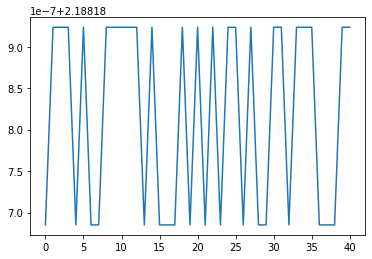

In [11]:
loss_mse = losses.MeanSquaredError()
model.compile(optimizers.Adam(clipnorm=1),loss=loss_mse)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=40)
history = model.fit(real_x,prof_true[:4],epochs=3000,callbacks=[callback],verbose=0)
plt.plot(history.history['loss'])
plt.show()

In [12]:
new = regress(test_x)
new==out

<tf.Tensor: shape=(1, 200), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  

In [13]:
inputs = [[3., 5., 2.]]
x = np.array(inputs)
weights=np.array([[11.,20.,3.,12.,9.,5.],[1.,2.,6.,3.,8.,4.],[10.,4.,8.,3.,11.,13]])

In [14]:
model = models.Sequential([
    layers.Dense(6,input_dim=3,trainable=False,activation="linear")
])

model.layers[0].set_weights([weights, np.zeros(6)])
model.layers[0].get_weights()

[array([[11., 20.,  3., 12.,  9.,  5.],
        [ 1.,  2.,  6.,  3.,  8.,  4.],
        [10.,  4.,  8.,  3., 11., 13.]], dtype=float32),
 array([0., 0., 0., 0., 0., 0.], dtype=float32)]

In [15]:
regress = lambda x: model(x)
out=regress(x)

In [16]:
print(out)

tf.Tensor([[58. 78. 55. 57. 89. 61.]], shape=(1, 6), dtype=float32)


In [17]:
combo = 0
for i in range(len(inputs[0])):
    combo += inputs[0][i]*weights[i]
print(combo)
combo==out[0]

[58. 78. 55. 57. 89. 61.]


<tf.Tensor: shape=(6,), dtype=bool, numpy=array([ True,  True,  True,  True,  True,  True])>

In [18]:
# new_inputs = [[1.,2.,3.],[4.,2.,6.],[8.,3.,5.],[11.,5.,8.]]
simple_weights = np.array([[1.,2.,3.,4.,5.,6.],[1.,2.,3.,1.,2.,3.],[1.,2.,1.,2.,1.,2.]])

In [19]:
final_model = models.Sequential([
    layers.Dense(6,input_dim=3,trainable=False,activation="linear"),
    layers.Dense(200,input_dim=6,trainable=False,activation="linear")
])

final_model.layers[0].set_weights([simple_weights, np.zeros(6)])
final_model.layers[1].set_weights([pca.components_, np.zeros(200)])

regress_final = lambda x: final_model(x)

In [20]:
test_in = np.array([[1.,1.,1.]])
bleh=regress_final(test_in)

In [21]:
pre_tot=0
for i in range(len(test_in[0])):
    pre_tot += test_in[0][i]*simple_weights[i]

tot=0
for i in range(len(pre_tot)):
    tot += pre_tot[i]*pca.components_[i]
tot==bleh

<tf.Tensor: shape=(1, 200), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  

In [22]:
pca.components_[0] + 100

array([100.      ,  99.99942 ,  99.99907 ,  99.99873 ,  99.998405,
        99.998085,  99.99777 ,  99.99746 ,  99.997154,  99.99684 ,
        99.99653 ,  99.99621 ,  99.995895,  99.99558 ,  99.99527 ,
        99.99494 ,  99.9946  ,  99.994255,  99.99391 ,  99.993546,
        99.99319 ,  99.992836,  99.99249 ,  99.99215 ,  99.99179 ,
        99.99143 ,  99.99108 ,  99.990746,  99.99041 ,  99.99008 ,
        99.98976 ,  99.98944 ,  99.98911 ,  99.988785,  99.98848 ,
        99.988174,  99.98787 ,  99.98757 ,  99.98728 ,  99.986984,
        99.986694,  99.986404,  99.986115,  99.98584 ,  99.98556 ,
        99.985275,  99.985   ,  99.98473 ,  99.98446 ,  99.984184,
        99.98392 ,  99.98365 ,  99.98337 ,  99.9831  ,  99.982834,
        99.98255 ,  99.98228 ,  99.981995,  99.98171 ,  99.98143 ,
        99.98115 ,  99.98087 ,  99.98059 ,  99.9803  ,  99.98002 ,
        99.97972 ,  99.97943 ,  99.979126,  99.97882 ,  99.978516,
        99.9782  ,  99.97788 ,  99.977554,  99.97723 ,  99.976